# Training a Random Forest Model over a CORINE Dataset using Google Earth Engine with the Python API

This Jupyter Notebook demonstrates how to train a random forest model over a CORINE dataset using Google Earth Engine with the Python API. The goal is to classify land cover categories based on the CORINE data and create decision trees using the random forest algorithm. We will also use geemap to visualize the results and save the decision trees locally.

## Workflow Overview
The workflow consists of the following steps:

1. Set up the environment: Import the necessary libraries and authenticate our Earth Engine account.

2. Define the study area: Use GEE assets (tables or shapefiles) to define the study area.

3. Loop through the years: Train over the relevant Corine data by looping through the years.

4. Return the created decision trees: Return the created decision trees with accuracy assessment details.

5. Saving the classifier will allow us to classify a more continuous timeseries.

## Useful to Know: 

- Here, the classifiers are saved locally for re-use. Unfortunately, due to server limits, a trained model cannot exceed 10MB before memory limits are encountered.

- The underlying landsat timeseries is created using an adaptation of the landTrendr module, adapted and simplified here for efficiency. It accomplishes creating the image series and band calculation. This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2.

- The classification routine has been implemented here by Mike O'Hanrahan for their MSc graduation thesis project.

This workflow provides a useful tool for classifying land cover categories based on the CORINE dataset, making it useful for various applications such as land use and land cover change analysis, environmental monitoring, and more. The workflow is flexible and can be adapted for different datasets and study areas. By using geemap for visualizing the results and saving the decision trees locally, this notebook provides an easy-to-use and efficient method for training random forest models over large geospatial datasets.

In [1]:
import ee
import geemap
import geemap.ml as ml
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
import datetime
import pytz


today = dt.today()
print("Today is: ", today)

Today is:  2023-04-24 12:09:58.811103


## GEE Authentication

Before using the Earth Engine Python API, we need to authenticate our account. The authentication step is required for the first time you use Earth Engine in a new session and roughly every week thereafter.

To authenticate, run the following cell and follow the prompts to log into your Earth Engine account. You will then be prompted to copy and paste the authentication code into the box provided. Once you have pasted the code, press enter to save the token.


In [2]:
# ee.Authenticate()
geemap.ee_initialize()

## Hydroclimatic Information

The code reads a CSV file containing a list of catchment IDs and stores them as a list. The number of catchments in the list is printed to the console, followed by the list of catchment IDs. The code is designed to process hydroclimatic variables for a given set of catchments. The path and version of the input file are defined as variables at the beginning of the code. The CSV file contains a column called "ID" that lists the catchment IDs.

In [3]:
# set the path and version of the input data
p = '..'
version = 'Version_3_20230303'

# read in the list of catchment IDs from the input csv file
l = pd.read_csv(f"{p}/Inputs/{version}/GB.csv").ID

# display the list of catchment IDs and convert it to a Python list
names = l.tolist()

# print the number of catchments and their IDs
print(f'{len(names)} catchments processed for hydroclimatic variables:\n \n{names}')


95 catchments processed for hydroclimatic variables:
 
[17005, 18001, 20007, 21017, 21023, 21024, 22001, 23004, 24004, 25006, 26003, 27035, 27042, 27047, 27051, 27071, 28046, 28072, 29003, 29009, 30004, 30012, 30015, 31023, 32003, 33018, 33019, 33029, 34011, 36003, 36009, 36010, 37005, 38026, 39017, 39019, 39020, 39025, 39034, 40005, 40011, 41022, 41025, 41027, 41029, 42003, 43014, 45005, 46003, 46005, 47009, 48003, 48004, 49004, 50002, 52010, 52016, 53006, 53008, 53009, 53017, 54008, 54018, 54025, 54034, 54036, 55008, 55014, 55016, 55026, 55029, 56013, 57004, 60002, 60003, 62001, 64001, 65005, 67010, 67018, 68005, 71001, 71004, 72005, 73005, 73011, 75017, 76014, 77004, 78004, 79002, 79004, 8009, 93001, 94001]


## Load the JS module

This notebook uses an adapted landTrendr package to construct time series of Landsat imagery for land cover detection. The package is optimized for deforestation event detection and can be used with the latest version of landTrendr available in the GEE asset, which has an Apache license and is free to use.

To load the package, we use the ltgee.buildSRcollection method. Note that if the JavaScript module is faulty, the cell below will not load.

In [4]:
oeel = geemap.requireJS()

Map = geemap.Map()

ltgee = geemap.requireJS(r'../JS_module/Adapted_LT_v7.3.js')

#ltgee.availability  #all functions within the javascript module


IMPORTANT! Please be advised:
- This version of the Adapted_LT.js modules
  uses some code adapted from the aut/or: @author Justin Braaten (Google) * @author Zhiqiang Yang (USDA Forest Service) * @author Robert Kennedy (Oregon State University)
The latest edits to this code occur: 08/03/2023 for the adaptation efforts by @Mike OHanrahan (TU DELFT MSc research)


## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on their GEE, the assets used in the CATAPUCII project will be made publicly available in the @mohanrahan repository

Assigning some useful variables for later classification

Catchment Assets are available at this address:

https://code.earthengine.google.com/?asset=projects/mohanrahan/assets/CATAPUCII_Catchments


## Assigning useful variables

- The asset_dir will point to the shapefile loaded as a GEE table asset. 
- crs is important for reprojection and scaling (which will affect area calculations)
- RGB_VIS is for landsat RGB visual parameters
- start day defines the beginning of the seasonal composite period
- maskThese applies a mask (renders Null/NA/Transparent) to those majority pixels in landsat imagery

In [5]:
# Directory where assets are stored
asset_dir = 'projects/mohanrahan/assets'

# Asset ID for catchment boundaries
catchment_asset = 'CATAPUCII_Catchments/CAMELS_GB_catchment_boundaries'

# Name of the dataset
dataset = 'CAMELS_GB'

# Column string to identify catchments
col_string  = 'ID'

# Coordinate reference system, GB is british national grid
crs = 'EPSG:27700'

# Figure number for plotting
fignum = 0

# RGB visualization settings for Landsat imagery
RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

#Classified image visualisation
lc_vis = {'bands':['landcover'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}

#Classified image visualisation
class_vis = {'bands':['classification'], 'min':1, 'max':5, 'palette':['#E6004D', '#FFFFA8', '#80FF00', '#A6A6FF', '#00CCF2']}

# Start and end years for Landsat data collection
startYear = 1984
endYear = 2022

# Start and end days for Landsat data collection
startDay = '06-20'
endDay = '08-31'

# List of images to be masked from Landsat collection
maskThese = ['cloud', 'shadow', 'snow',]

# List of bands to include in Landsat collection
bandList = ["B1", "B2", "B3", "B4", "B5", "B7", 
           'NBR', 'NDMI', 'NDVI', 'NDSI', 'EVI','GNDVI', 
           'TCB', 'TCG', 'TCW', 'TCA', 'NDFI',] 


## The Table Data

### Code:
The code imports a feature collection of catchment boundaries from the Google Earth Engine (GEE) asset directory, calculates the area of each catchment in square kilometers and pixels, sets a unique identifier for each catchment, and filters and sorts the catchment collection based on the area. It then converts the filtered and sorted collection to a pandas dataframe, selects only the catchments that are specified in a list of catchment names, and saves the resulting table to an Excel file.

### Summary:
The code fetches catchment boundaries from a GEE asset directory and calculates their areas in both square kilometers and pixels. Then, it assigns a unique identifier to each catchment and filters and sorts them based on their area. It saves a subset of the resulting catchment table that contains only the catchments specified in a list of names to an Excel file.

In [6]:
# Define the feature collection from asset directory and catchment asset name
table = ee.FeatureCollection(f"{asset_dir}/{catchment_asset}")

# Define a function to calculate the area of each geometry in square kilometer
def set_area_km2(feature):
    '''
    Calculate the area of each geometry in square kilometer
    '''
    area = feature.geometry().area().divide(1000*1000)
    setting = feature.set('area_km2', area)
    return setting

# Define a function to calculate the area of each geometry in pixels
def set_area_pixel(feature):
    '''
    Calculate the area of each geometry in pixels
    '''
    aoi = feature.geometry()
    area = ee.Image.pixelArea().divide(1e6).clip(aoi).select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        'crs':crs,
        'maxPixels':1e13,
        'bestEffort':True,
        }).get('area')
    setting = feature.set('pixel_area', area)
    return setting

# Define a function to set the system ID as a column
def set_id(feature):
    '''
    Set the system ID as a column
    '''
    getting_name = ee.String(feature.get('system:index'))
    setting_id = feature.set({'system_index':getting_name,})
    return setting_id

# Calculate the area of each geometry and set ID column and pixel area column
table_area = table.map(set_area_km2).map(set_id).map(set_area_pixel)

# Filter out geometries with area_km2 equal to zero and sort by area from largest to smallest
Filtered_Sorted = table_area.filter(ee.Filter.gt('area_km2', 0)).sort('area_km2', False)

# Convert the sorted table to a Pandas dataframe and set the index to 'system_index'
down = geemap.ee_to_pandas(Filtered_Sorted).set_index(['system_index'])

# Select the rows of 'down' where the column specified by 'col_string' is in the list 'names'
df1 = down.loc[down[col_string].isin(names)]

# Get the system_index values as a list
sys_index = df1.index.to_list()

# Display the filtered table
display(df1)

# Print the number of features in the filtered table
print(len(df1))

# Convert the filtered and sorted table to a Pandas dataframe
gdf = geemap.ee_to_pandas(Filtered_Sorted)

# Create a directory for the output if it doesn't exist
if not os.path.exists(f'../Outputs/{dataset}/'):
    os.makedirs(f'../Outputs/{dataset}/')

# Export the filtered and sorted table to an Excel file
gdf.to_excel(f'../Outputs/{dataset}/{dataset}_catchment_table.xlsx', index=0)


,pixel_area,area_km2,SOURCE,VERSION,ID,EXPORTED,ID_STRING
system_index,,,,,,,
00000000000000000088,1355.679450,1349.764903,National River Flow Archive,1.3,27071,1518422400000,27071
00000000000000000235,1145.767150,1140.885961,National River Flow Archive,1.3,71001,1518422400000,71001
000000000000000001c0,1125.603290,1121.172318,National River Flow Archive,1.3,54008,1518422400000,54008
00000000000000000207,897.948531,894.478359,National River Flow Archive,1.3,62001,1518422400000,62001
0000000000000000025a,798.157955,794.507522,National River Flow Archive,1.3,79002,1518422400000,79002
...,...,...,...,...,...,...,...
0000000000000000021b,12.768404,12.719149,National River Flow Archive,1.3,67010,1518422400000,67010
00000000000000000082,11.353532,11.304831,National River Flow Archive,1.3,27047,1518422400000,27047
000000000000000001df,10.506362,10.466687,National River Flow Archive,1.3,55008,1518422400000,55008


95


In [7]:
geom_north = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -5.735496279653574,
        56.12064673783441
      ],
      [
        -3.5711896390285736,
        56.12064673783441
      ],
      [
        -3.5711896390285736,
        57.83265981722564
      ],
      [
        -5.735496279653574,
        57.83265981722564
      ],
      [
        -5.735496279653574,
        56.12064673783441
      ]
    ]
  ]
}

geom_middle = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -4.439109560903574,
        53.67024054287634
      ],
      [
        -0.26430487340357356,
        53.67024054287634
      ],
      [
        -0.26430487340357356,
        56.08388347961458
      ],
      [
        -4.439109560903574,
        56.08388347961458
      ],
      [
        -4.439109560903574,
        53.67024054287634
      ]
    ]
  ]
}

geom_south = {
  "geodesic": False,
  "type": "Polygon",
  "coordinates": [
    [
      [
        -5.372947451528574,
        50.23970424688909
      ],
      [
        1.1694109469089264,
        50.23970424688909
      ],
      [
        1.1694109469089264,
        53.458178051023836
      ],
      [
        -5.372947451528574,
        53.458178051023836
      ],
      [
        -5.372947451528574,
        50.23970424688909
      ]
    ]
  ]
}

geom_tup_ls = [('north_zone', geom_north), ('middle_zone', geom_middle), ('south_zone',geom_south)]

aoi = ee.Geometry(geom_middle)

catchments = Filtered_Sorted.filter(ee.Filter.inList(col_string, ee.List(names)))

def aoi_list_to_df(catchments, tup):
    '''
    Takes a list of tuples containing [(zone names, geojson geometry),...]
    '''
    for i, j in tup:
        print('i', i)
        
        aoi = ee.Geometry(j)
        
        # Convert the filtered and sorted table to a Pandas dataframe
        gdf = geemap.ee_to_pandas(catchments.filter(ee.Filter.bounds(aoi)))
        
        # Export the filtered and sorted table to an Excel file
        gdf.to_excel(f'../Outputs/{dataset}/{dataset}_{i}_catchment_table.xlsx', index=0)

aoi_list_to_df(catchments, geom_tup_ls)

Map = geemap.Map()

Map.setOptions('TERRAIN')
Map.addLayer(catchments, {'color': 'green'}, 'green: Included')
Map.addLayer(catchments.filter(ee.Filter.bounds(aoi).Not()), {'color':'red'}, 'red: Not Included')
Map.centerObject(Filtered_Sorted, 7)
Map.addLayer(aoi, {'color':'yellow'}, 'area trained')

Map

i north_zone
i middle_zone
i south_zone


Map(center=[53.49722684216607, -2.3029239738111555], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [8]:
def clip_collection(image: ee.Image) -> ee.Image:
    '''
    Clip an image to the area of interest and return a copy of the clipped image.

    Input:
        image (ee.Image): the image to clip
    
    Output:
        ee.Image: the clipped image
    '''
    return image.clip(aoi).copyProperties(image)


def extractArea(item) -> ee.List:
    '''
    Extract the area of a classified land cover class as a list of class number and area.

    Input:
        item (ee.Dictionary): a dictionary containing classification and pixel area information
    
    Output:
        ee.List: a list of class number and area
    '''
    
    areaDict = ee.Dictionary(item)
    classNumber = ee.Number(areaDict.get('classification')).format()
    area = ee.Number(areaDict.get('sum')).divide(1e6)
    return ee.List([classNumber, area])


def classArea(classified_image: ee.Image, scale: int) -> ee.List:
    '''
    Calculate the area of each classified land cover class for an image at a given scale.

    Input:
        classified_image (ee.Image): classified image
        scale (int): scale of the image in meters
    
    Output:
        ee.List: a list of class numbers and areas for the image
    '''
    
    areaImage = ee.Image.pixelArea().addBands(classified_image)
    
    areas = areaImage.reduceRegion(**{
            'reducer':ee.Reducer.sum().group(**{'groupField':1, 'groupName':'classification'}),
            'geometry':aoi,
            'scale':scale,
            'maxPixels':1e10,
            'bestEffort':True,
    })
    
    classAreas = ee.List(areas.get('groups'))
    
    classAreasLists = classAreas.map(extractArea)
    
    return classAreasLists

def msToDate(milliseconds: int) -> datetime.datetime:
    '''
    Convert a timestamp in milliseconds to a datetime object.

    Input:
        milliseconds (int): a timestamp in milliseconds
    
    Output:
        datetime.datetime: a datetime object corresponding to the timestamp
    '''
    
    base_datetime = datetime.datetime(1970, 1, 1)
    delta = datetime.timedelta(0, 0, 0, milliseconds)
    target_datetime = base_datetime + delta
    return target_datetime

def dataframeAreas(i: int, yc: int, classified: ee.Image, trainingClassImage: ee.Image, ms: int, classImageYear: int, name: str, accuracy: float) -> pd.DataFrame:
    '''
    Calculate the area of each classified land cover class for an image, given its classification and training images, and return a DataFrame of the results.

    Input:
        i (int): index of the current image in the collection
        yc (int): year count (number of years since the first year in the collection)
        classified (ee.Image): classified image
        trainingClassImage (ee.Image): training image with land cover classes
        ms (int): timestamp of the image in milliseconds
        classImageYear (int): year of the image used for classification
        name (str): name of the catchment
        accuracy (float): accuracy of the classifier used for classification
    
    Output:
        pivoted (pd.DataFrame): a pivoted DataFrame with columns representing land cover classes and rows representing image dates, area of each class for CORINE and random forest classifications, and catchment name, training year, and accuracy information
    '''
    
    ls1 = pd.DataFrame(classArea(classified, 30).getInfo(), columns=['class', 'area_RF'])
    ls2 = pd.DataFrame(classArea(trainingClassImage, 100).getInfo(), columns=['class', 'area_CORINE'])

    merged = ls1.merge(ls2, how='inner', on='class')
    merged['image_date'] = ms
    pivoted = merged.pivot(index='image_date', columns='class', values=['area_CORINE', 'area_RF'])
    pivoted['training', 'year_trained'] =  classImageYear
    pivoted['area_CORINE', '6'] = 0
    pivoted['catchment', 'area'] = pivoted.iloc[0, 0:5].sum()
    pivoted['area_RF', '6'] = pivoted.catchment.area - pivoted.iloc[0, 6:10].sum() 
    pivoted['catchment', 'name '] = name
    pivoted['testing', 'accuracy'] = accuracy
    pivoted['ind'] = str(i)+'_'+str(yc)
    pivoted.fillna(0)
    
    return pivoted


    
def saveClassifierToCSV(classifier: ee.Classifier, name: str, yc: int) -> None:
    '''
    Save decision trees from a random forest classifier to CSV files.

    Input:
        classifier (ee.Classifier): a trained random forest classifier
        name (str): name of the catchment
        yc (int): year count (number of years since the first year in the collection)
    
    Output:
        None
    '''
    
    decisionTrees = ee.List(classifier.explain().get('trees')).getInfo()
    folder='Trees'
    
    print('saving...')

    var = f'../Outputs/{dataset}/{folder}/'

    if not os.path.exists(var):
        print('created')
        os.makedirs(var)

    ml.trees_to_csv(decisionTrees, f'../Outputs/{dataset}/Trees/{name}_{yc}')
    
def calculate_classification_stats(confusion_matrix):
    # Calculate the total number of predictions
    total = np.sum(confusion_matrix)
    
    # Calculate the number of true positives, false positives, false negatives, and true negatives
    true_positives = np.diag(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    true_negatives = total - (true_positives + false_positives + false_negatives)

    # Calculate the producer and consumer accuracy
    producer_accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    consumer_accuracy = true_positives / np.sum(confusion_matrix, axis=0)

    # Calculate the precision, recall, and F-score
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    fscore = 2 * ((precision * recall) / (precision + recall))

    # Calculate the overall accuracy
    overall_accuracy = np.sum(true_positives) / total

    # Calculate Cohen's kappa coefficient
    observed_agreement = np.sum(true_positives + true_negatives) / total
    expected_agreement = np.sum(np.sum(confusion_matrix, axis=0) * np.sum(confusion_matrix, axis=1)) / (total ** 2)
    kappa = (observed_agreement - expected_agreement) / (1 - expected_agreement)

    # Normalize kappa to a range of -1 to 1
    normalized_kappa = kappa / 10

    # Return the consumer accuracy, producer accuracy, F-score, overall accuracy, and kappa
    return consumer_accuracy, producer_accuracy, fscore, overall_accuracy, normalized_kappa

In [9]:

id_ls = 'used_images'
SR_t = 'SR_timeseries'
RF_c = 'RF_classification/'
Tr = 'Trees'


folder_list = [id_ls, SR_t, RF_c, Tr]

for folder in folder_list:
    
    var = f'../Outputs/{dataset}/{folder}'
    
    if not os.path.exists(var):
        print('created')
        os.makedirs(var)


### areas calculated from: 

https://code.earthengine.google.com/cc1f2371404daf318b08060def5a1aa5

- This code defines a list of land cover class names and three dictionaries of land cover class areas in square kilometers for different regions of interest. 
- It then extracts the trained area in square kilometers from the area_for_weighted_sample dictionary and calculates the total. 
- It calculates the percentage of each land cover class within the total trained area and a weight for each land cover class based on its percentage of the total trained area. 
- Finally, it prints the weights for each land cover class to the console.

In [10]:
# Define a list of land cover class names
class_names = ['Artificial', 'Agricultural', 'Forest and Semi-Natural', 'Wetlands', 'Waterbodies']

full_basin_500 = { #computed at a 500m scale
  "1": 564.8738188768993,
  "2": 11118.882881893012,
  "3": 4459.109223972432,
  "4": 1292.0259474223649,
  "5": 48.647703153737744
}

area_full_100 = { #computed at a 100m scale
  "1": 591.3541867334484,
  "2": 11046.02886733322,
  "3": 4486.944288416541,
  "4": 1269.405212174017,
  "5": 48.28035556339614
}



area_for_weighted_sample = area_full_100

# Extract the trained area in square kilometers from the area_for_weighted_sample dictionary and calculate the total
trained_area_km = [area_for_weighted_sample[i] for i in area_for_weighted_sample.keys()]
tot = np.sum(trained_area_km)

# Calculate the percentage of each land cover class within the total trained area
area_full_pct = np.array([area_for_weighted_sample[i] / tot for i in area_for_weighted_sample.keys()])

# Calculate a weight for each land cover class based on its percentage of the total trained area
weights = [int(p * 5000) for p in area_full_pct]

# Print the weights for each land cover class to the console
weight_zip = zip(class_names, weights)
print(f'Points from percentage area:\n{[(cla, point) for cla, point in weight_zip]}')
print(area_full_pct)

Points from percentage area:
[('Artificial', 169), ('Agricultural', 3166), ('Forest and Semi-Natural', 1286), ('Wetlands', 363), ('Waterbodies', 13)]
[0.03390401 0.63330012 0.25724922 0.0727786  0.00276805]


## Defining the name of the output
- This will dictate whether the distribution of points is weighted and or tuned



In [11]:
# saved_classifier_name = 'GB_Max_untuned'
saved_classifier_name1 = 'GB_South_HC_tuned'
saved_classifier_name2 = 'GB_Middle_HC_tuned'
saved_classifier_name3 = 'GB_North_HC_tuned'

scn_list = [saved_classifier_name1, saved_classifier_name2, saved_classifier_name3]

In [12]:
hyperparameters = {
    'number_of_trees':120,
    'variables_per_split':8,
    'minimum_leaf_population':1,
    'bag_fraction':0.6,
    'max_nodes':330,
    'seed':0
}


classLoopParams = {'dataset':'CORINE',    #training dataset, no other than corine currently supported
               'trainingClassLevel':1, #classLevel determines the level of corine class simplification
               'customClassLevels':None,   #can provide some custom levels, not fully tested
               'numClasses':5,            #if trainingClassLevel is 1 then there are 5 classes, level is 2 then there are 15, 3 is 44. (CORINE land cover class grouping)
               'split':0.7,               #split the training and testing 0.7/0.3 (70% training, 30% accuracy testing). 
               'tileScale':2,            #tileScale higher number reduces likelihood of classifier running into a memory limit
                'distribution':'weighted',  # can be weighted or balanced, weighting is done be area proportion
               'weighting':list(area_full_pct),  # weighting based on area, percentages are passed , dictionaries do not pass to javascript code as well as lists
               'year_classified': [2018],   # classification year is , for classifiers saved, the same as the years available in the training dataset
                'hyperparameters': [hyperparameters['number_of_trees'],
                                   hyperparameters['variables_per_split'],
                                   hyperparameters['minimum_leaf_population'],
                                   hyperparameters['bag_fraction'],
                                    hyperparameters['max_nodes'],
                                   hyperparameters['seed']] #hyperparameters are passed to  via a list, not a dictionary. 
              }


## This loop is set to generate all classifiers, it will output CSV classifiers

CSV classifiers save locally for all available training years in the corine dataset (or years set by the year classified loop parameter). The training area is the combined geometry of the whole meuse basin and are uploaded from client to server in the form of a decision Tree Ensemble. 

- Creating the classifier we also need to generate the training accuracy assessing  "" confusion matrix ""

from the confusion matrix: (overall) accuracy, kappa coefficient, producer's accuracy, consumers'accuracy. 

This will be assessed three times in the report, from a 

1. balanced non-tuned () [1990, 2000, 2006, 2012, 2018]
2. then weighted, non-tuned
3. then a weighted tuned classifier

In [13]:
t0 = dt.today()

confusion_matrices = []

error_matrices = []

accuracy_dictionaries = []

classArea_df = pd.DataFrame()

validation_combined_df = pd.DataFrame()

print(f'begin loop: {t0}')


for i, (zone_name, geojson) in enumerate(geom_tup_ls[:]):
    
    aoi = ee.Geometry(geojson)
    
    area = aoi.area(1).divide(1e6)
    
    t1 = dt.today()
    
    name = scn_list[i]
    
    print(f'{t1}\nDataset: {dataset}, \nTraining area: {name}, \nSurface Reflectance Processing ...\n')
    
    annual_med = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese, [''])#.map(clip_collection) #much slower when clipped
    
    annual_med_calc = ltgee.transformSRcollection(annual_med, bandList)
    
    saved_classifier_name = name

    t3 = dt.today()
    
    print(f'\nstep 2: Initialize classification routine: {t3}')
    
    if dataset == 'CAMELS_GB':
        '''
        
        The years that we train on are not necessarily the same as the years we classify: 
        - first define the years to return that will be relevant to the decadal analysis (matching the hydroclimatic decades)
        - Then use conditions to define which training set corresponds best to the image to be classified. 
        - LATER: Will need to use a trained classifier, perhaps the 'best performer', to classify the USA dataset. 
            - Best accuracy may be to take a classifier that samples all 4 categories
        
        '''
        
        if saved_classifier_name[-7:]=='untuned' or saved_classifier_name[-8-8:]=='untuned_balanced':
            tuned = 'not_tuned'
            print('not_tuned classifier')
        else:
            tuned = 'tuned'
            print('classifier is tuned')
        
        
        
        for j, yc in enumerate(classLoopParams['year_classified']):
            '''
            Define the training image, then the image to classify, adding slope and elevation bands

            Corine Representative Classes:
            || 1989 -> 1998 | 1999 -> 2001 | 2005 -> 2007 | 2011 -> 2012 | 2017 -> 2018 ||
            ||   "2000"     |    "2000"    |    "2006"    |     "2012"   |     "2018"   ||

            Training "image year above" --> classify the relevant Landsat date range below:
            || 1984 -> 1998 | 1999 -> 2003 | 2004 -> 2009 | 2010 -> 2014 | 2015 -> ...  || 
            
            '''

            if yc >= 1984 and yc < 2004:
                classImageYear = 2000

            elif yc >= 2004 and yc < 2010:
                classImageYear = 2006

            elif yc >= 2010 and yc < 2015:
                classImageYear = 2012

            elif yc >= 2015:
                classImageYear = 2018

            else:
                print('ERROR: year to classify out of range[1984 +]')
                break
            
            print('year classified', yc)
            
            #the image from the collection that we want to classify
            imageFromCollection = ee.ImageCollection(annual_med_calc).filterDate(str(yc)+'-'+startDay, str(yc+1)+'-'+endDay).first()
            
            #image from training dataset e.g. CORINE is selected and simlified... 
            trainingClassImage = ltgee.createTrainingImage(str(classImageYear), 
                                                           classLoopParams['dataset'], 
                                                           classLoopParams['trainingClassLevel'], 
                                                           aoi)
            
            
            #TODO: reproject to 30m native resolution
            clipped = imageFromCollection.clip(aoi)
            
            #Adding the elevation and slope band calculations to each image
            print('Adding Terrain...')
            imageToClassify = ltgee.addTerrainBand(clipped, aoi)
        
            
            #getting the date of the image and converting it from milliseconds since 1970 (Earth engines preferred datetime)
            ms = msToDate(ee.Date(imageToClassify.get('system:time_start')).getInfo()['value'])
            
            print('Generating GCP...')
            #the points used for training the classifier are randomly distibuted amongst the classes extracting a profile of spectral and terrain
            points = ltgee.genGCP(trainingClassImage, 
                                  imageToClassify, 
                                  classLoopParams['numClasses'], #set at 5 usually
                                  classLoopParams['split'],      #set at 70/30
                                  classLoopParams['tileScale'], 
                                  aoi, 
                                  classLoopParams['distribution'], #either balanced or weighted
                                  classLoopParams['weighting'])
            
            
            # 70% of the points are allocated to training
            training = points['training']
            
            # 30% of the points are allocated to classification
            testing = points['testing']
            
            t5 = dt.today()
            
            print('Building classifier...')
            
            #classifier training with predefined number of trees using training points
            classifier = ltgee.classifier(imageToClassify, training, tuned, classLoopParams['hyperparameters'])
            
            t6 = dt.today()
            
            print('saving the classifier..')
            #saving decision trees for later use
            saveClassifierToCSV(classifier, name, yc)
            
            
            print('saved')
            
            '''
            Accuracy metrics saved, firstly the testing metrics, generated via the confusion matrix, then similarly the Validation accuracy metrics (from the 30% split test). 
            A dataframe is generated, populated with the overall accuracy, kappa score, fscore, producers accuracy and consumers accuracy. 
            
            The matrices (confusion/training & error/validation) are saved as individual npy files, and upon completion of a complete loop the list of all matrices are saved as a combined list of matrices. 
            
            '''
            
            print('Asessing classifier accuracy...')
            
            confusion_matrix = classifier.confusionMatrix()
            
            cm = np.array(confusion_matrix.getInfo())[1:, 1:]
            
            consumers_accuracy, producers_accuracy, fscore, accuracy, kappa = calculate_classification_stats(cm)
            
            np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_confusionMatrix_{classImageYear}.npy', arr=cm, allow_pickle=True)   #saving the confusionMatrix to allow for later access in assessing the bias
            
            confusion_matrices.append(cm)

            acc_dict = {'train_valid':'training',
                        'tree_name':f'{saved_classifier_name}_{tuned}',
                        'year':classImageYear, 
                        'o_accuracy':accuracy,
                        'kappa':kappa,
                        'fscore1':fscore[0],
                        'fscore2':fscore[1],
                        'fscore3':fscore[2],
                        'fscore4':fscore[3],
                        'fscore5':fscore[4],
                        'p_accuracy1':producers_accuracy[0],
                        'p_accuracy2':producers_accuracy[1],
                        'p_accuracy3':producers_accuracy[2],
                        'p_accuracy4':producers_accuracy[3],
                        'p_accuracy5':producers_accuracy[4],
                        'c_accuracy1':consumers_accuracy[0],
                       'c_accuracy2':consumers_accuracy[1],
                       'c_accuracy3':consumers_accuracy[2],
                       'c_accuracy4':consumers_accuracy[3],
                       'c_accuracy5':consumers_accuracy[4]}
            
            acc_df = pd.DataFrame(acc_dict, index=[0])
            acc_df.to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_accuracy_metrics_{classImageYear}.xlsx')
            
            importance = ee.Dictionary(classifier.explain()).get('importance').getInfo()
            
            validation_combined_df = validation_combined_df.append(acc_df)
            
            pd.DataFrame(importance, index=[0]).to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_importance_{classImageYear}.xlsx')
            
            '''
            Validation metrics saved
            '''
            
            print('Asessing classifier validation accuracy...')
            
            validated = testing.classify(classifier)
            
            test_matrix = validated.errorMatrix('landcover', 'classification')
            
            em = np.array(test_matrix.getInfo())[1:,1:]
            
            consumers_accuracy, producers_accuracy, fscore, accuracy, kappa = calculate_classification_stats(em)
            
            val_dict = {'train_valid':'validation',
                        'tree_name':f'{saved_classifier_name}_{tuned}',
                        'year':classImageYear, 
                        'o_accuracy':accuracy,
                        'kappa':kappa,
                        'fscore1':fscore[0],
                        'fscore2':fscore[1],
                        'fscore3':fscore[2],
                        'fscore4':fscore[3],
                        'fscore5':fscore[4],
                        'p_accuracy1':producers_accuracy[0],
                        'p_accuracy2':producers_accuracy[1],
                        'p_accuracy3':producers_accuracy[2],
                        'p_accuracy4':producers_accuracy[3],
                        'p_accuracy5':producers_accuracy[4],
                        'c_accuracy1':consumers_accuracy[0],
                       'c_accuracy2':consumers_accuracy[1],
                       'c_accuracy3':consumers_accuracy[2],
                       'c_accuracy4':consumers_accuracy[3],
                       'c_accuracy5':consumers_accuracy[4]}
                        
            val_df = pd.DataFrame(val_dict, index=[0])
            
            val_df.to_excel(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_validation_metrics_{classImageYear}.xlsx')
            
            np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_validationMatrix_{classImageYear}.npy', arr=em, allow_pickle=True)   #saving the confusionMatrix to allow for later access in assessing the bias
            
            print('Classifying...')
            
            classified = imageToClassify.classify(classifier)
            
            validation_combined_df = validation_combined_df.append(val_df)
            
            t2 = dt.today()
            
            print(f'time for {classImageYear} data = {t2 - t3}')
            
    else:
        print('classification routine for this dataset is not yet provided for')
    
    t4 = dt.today()
    print(f'step2: Done: {t4}, time taken: {t4-t3}')
    print(f'\nCatchment: {name}, total time: {t4-t1}\n---------------')
    
    if ind == sys_index[0]:
        break

classArea_df.to_excel(f'../Outputs/{dataset}/RF_classification/{saved_classifier_name}_{tuned}_combinedAreas.xlsx')

np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_confusionMatrices_All_{classImageYear}.npy', arr=confusion_matrices, allow_pickle=True)  

np.save(f'../Outputs/{dataset}/Trees/{saved_classifier_name}_{tuned}_errorMatrices_All_{classImageYear}.npy', arr=error_matrices, allow_pickle=True)  


tfinal = dt.today()

print(f'END LOOP: Full routine finished: {tfinal} \nTime taken: {tfinal-t0}')

begin loop: 2023-04-24 12:10:33.005287
2023-04-24 12:10:33.007299
Dataset: CAMELS_GB, 
Training area: GB_North_HC_tuned, 
Surface Reflectance Processing ...


step 2: Initialize classification routine: 2023-04-24 12:10:34.348148
classifier is tuned
year classified 2018
Adding Terrain...
Generating GCP...
Building classifier...
saving the classifier..
saving...
saved
Asessing classifier accuracy...
Asessing classifier validation accuracy...
Classifying...
time for 2018 data = 0:02:09.604496
step2: Done: 2023-04-24 12:12:43.952644, time taken: 0:02:09.604496

Catchment: GB_North_HC_tuned, total time: 0:02:10.945345
---------------


NameError: name 'ind' is not defined

In [ ]:
year_classified = [1990, 2000, 2006, 2012, 2018]

for year in year_classified:
    classArea_df.groupby(('training', 'year_trained')).get_group(year).sort_values(by=('testing', 'accuracy'), ascending=False).to_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year}.xlsx')

In [21]:
fscore



array([0.525     , 0.89182058, 0.71255061, 0.525     , 0.5       ])

In [ ]:
catchment = ['Chooz', 'Chooz', 'Chooz', 'treignes', 'Chooz']
accuracy = [0.789369, 0.783634, 0.803112, 0.796622, 0.796321]
group = pd.read_excel(f'../Outputs/meuse/RF_classification/classifier_ranking_{year_classified[4]}.xlsx', header=[0,1], index_col=0, parse_dates=True).dropna()
group

In [ ]:

fig,ax = plt.subplots(figsize=(10,6.18))
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('testing',     'accuracy')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='Mean Line')
ax.scatter(year_classified, accuracy, marker='+', c='r', label='Chosen Classifier')
ax.set_ylim(0.6, 0.9)
ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Validation Accuracies across all Training Years');

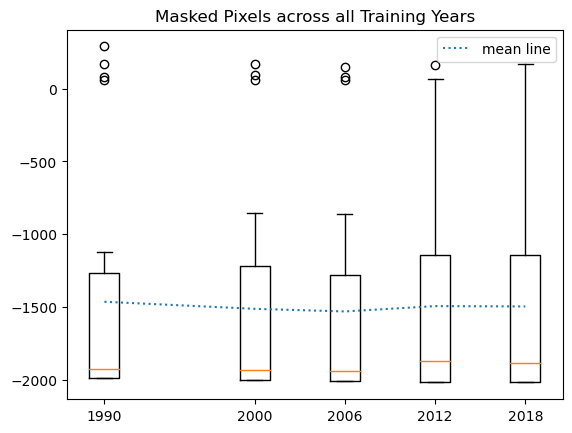

In [223]:
fig,ax = plt.subplots()
#ax.set_xticks(list(np.arange(1984, 2022)), list(np.arange(1984, 2022)))
groups = classArea_df.groupby((   'training', 'year_trained'))
ls = []
means = []
for year in year_classified:
    y = groups.get_group(year)[('area_RF',     '6')].values
    ls.append(y)
    means.append(np.mean(y))
ax.boxplot(ls, positions=year_classified, widths=2, meanline=True)
ax.plot(year_classified, means, ls=':', label='mean line')
# ax.set_ylim(0.6, 0.9)
# ax.set_xlim(1984, 2022)
ax.legend()
ax.set_title('Masked Pixels across all Training Years');

In [224]:
groups.get_group(1990)[('area_RF',     '6')].values

array([  170.04494064, -1121.04137693, -1990.        ,   288.9496701 ,
       -1188.77559444, -1507.10129803,    81.80562092, -1990.        ,
          57.5897379 , -1990.        , -1990.        , -1639.97102917,
       -1747.56122536, -1990.        , -1990.        , -1855.4575343 ,
       -1990.        , -1990.        , -1990.        , -1852.2925636 ,
       -1990.        , -1990.        ])

In [304]:
headers = ('catchment', 'year', 'classes')
ranking_classifiers = [ ('la Meuse Stenay', 2012, 4)]
#print(type(headers[0]))
df = pd.DataFrame(ranking_classifiers, columns=headers)#, dtype=[(headers[0], 'U')])#, (headers[1], int()), (headers[2], int())])
df.dtypes

catchment    object
year          int64
classes       int64
dtype: object

In [217]:
Map=geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(trainingClassImage, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Train on')
Map.addLayer(imageToClassify, {'band':['B3', 'B2','B1'], 'min':0, 'max':1200, 'gamma':0.9}, 'RGB')
Map.addLayer(classified, {'band':['landcover'], 'min':1, 'max':5, 'palette':['red', 'yellow', 'green', 'purple', 'blue']}, 'Classified')

Map

Map(center=[49.77390824509992, 4.868050388133598], controls=(WidgetControl(options=['position', 'transparent_b…

In [120]:
def maskedPixelCount(image, band, geom, scale):
    im = image.select(band)
    Pix = im.reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    unmaskPix = im.unmask(1).reduceRegion(**{
                                'reducer':ee.Reducer.count(),
                                'geometry':geom,
                                'scale':im.projection().nominalScale(),
                                'crs':im.projection(),
                                'maxPixels':1e9,
                                }).get(band)
    maskedPix = ee.Number(unmaskPix).subtract(ee.Number(Pix))
    return [Pix.getInfo(), unmaskPix.getInfo(), maskedPix.getInfo()]

def pixelToArea(pixels, scale):
    '''
    x [pixels] * y [sqm / pixel]
    --------------------------   = area [sq km]
        z [sqm / sqkm]
    '''
    return (pixels*scale)/1e6

In [284]:
pix1, unmaskPix1, maskedPixels1 = maskedPixelCount(imageToClassify, 'B1', aoi, 30)
pix2, unmaskPix2, maskedPixels2 = maskedPixelCount(classified, 'classification', aoi, 30)
pix3, unmaskPix3, maskedPixels3 = maskedPixelCount(trainingClassImage, 'landcover', aoi, 30)

1589.5336892619698

In [216]:
areaBand = ee.Image.pixelArea().divide(1e6)
image = classified.addBands(areaBand)

areas = image.select('area').reduceRegion(**{
        'reducer':ee.Reducer.sum(),
        'geometry':aoi,
        'scale':30,
        # 'crs':'EPSG:3035',
        'maxPixels':1e13,
        'bestEffort':True,
})

areas
#classAreasLists = classAreas.map(extractArea) #6191.08

In [206]:
(classAreas.getInfo() / 253 )

1579.1635123614628

In [268]:
ca = classArea(trainingClassImage, 100).getInfo()

# print('masked pixels in LS composite, area in sqKm:', pixelToArea(maskedPixels1, 30))

print('masked pixels in classified, area in sqKm:', pixelToArea(maskedPixels2, 30))

print('masked pixels in training, area in sqKm:', pixelToArea(maskedPixels3, 30))

In [283]:
df.area_CORINE.sum(axis=1)

date
2011-08-31 22:00:00    1589.539192
dtype: float64

In [263]:
df.year_trained

date
2011-08-31 22:00:00    2011
Name: year_trained, dtype: int64

In [ ]:
chart_min_region = chart.Image.series(**{
'imageCollection': clear_collection,
'reducer': ee.Reducer.min(),
'region': aoi,
'scale': scale,
'band': 'B1_min',
}).dataframe
chart_min_region

In [ ]:
Map.addLayer(imcol.first(), RGB_VIS, '')
Map.centerObject(aoi, 10)
Map

In [ ]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


In [ ]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [ ]:
annual

## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [ ]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [ ]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map